In [1]:
import bitstring
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

import initializations as init
import compression as comp

In [2]:
# We need input and output training data
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
train_samples = 5000

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_samples, test_size=10000)

In [3]:
### VERSION: WEIGHT MATRIX OF MPOS, BINARY INPUT ###

# We need to initialize each element of the weight matrix as an MPO
bits = 8  # FLOATS MUST BE 32 OR 64 BIT
W = []
MPO = init.initialize_random_MPO(num_sites=bits, bond_dim=1, phys_dim=2)

layer_inputs = 784
layer_outputs = 10
for i in range(layer_inputs):
    line = []
    for j in range(layer_outputs):
        line.append(MPO[:])
    W.append(line)
print("W Shape:", len(W), "x", len(W[0]))

def convert_vector_to_binary(vector, bits):
    vector_bin = []
    for value in vector:
        value_bin = bitstring.BitArray(float=value, length=bits)  # Add float=value for floats
        vector_bin.append(np.fromstring(value_bin.bin, np.int8) - 48)
    return vector_bin

def create_MPS_from_bit_string(vector_bin, IO):
    MPS_list = []
    for value in vector_bin:
        MPS = []
        for i, element in enumerate(value):
            if element == 0:
                MPS.append(np.array([1, 0]))
            elif element == 1:
                MPS.append(np.array([0, 1]))

            if IO == 'output':
                if i == 0 or i == len(value)-1:
                    MPS[-1] = MPS[-1][..., np.newaxis]
                else:
                    MPS[-1] = MPS[-1][..., np.newaxis, np.newaxis]
                    MPS[-1] = np.transpose(MPS[-1], (1, 2, 0))  # Maybe needs to be 2, 1, 0
        MPS_list.append(MPS)
    return MPS_list

for k in range(1):
    # Preprocessing for a given datapoint
    training_input = X_train[k]

    training_output = np.zeros(10)
    training_output[int(y_train[k])] = 1

    training_input = training_input.astype(int)
    training_output = training_output.astype(int)

    # Convert values to binary
    training_input_bin = []
    for value in training_input:
        input_bin = [int(x) for x in '{:08b}'.format(value)]
        training_input_bin.append(input_bin)

    training_output_bin = []
    for value in training_output:
        output_bin = [int(x) for x in '{:08b}'.format(value)]
        training_output_bin.append(output_bin)

    # Create input/output MPS for our training datapoint
    x = create_MPS_from_bit_string(training_input_bin, IO='input')
    y = create_MPS_from_bit_string(training_output_bin, IO='output')

    index_y = int(y_train[k])
    print(k, index_y)
    for index_x in range(len(x)):
        # Element to be updated
        weight = W[index_x][index_y]
        
        # Binary value corresponding to pixel value
        input_x = x[index_x]
        xW = []
        for i in range(len(weight)):
            if i == 0 or i == len(weight)-1:
                # Contract from top
                site = np.einsum('i, abi->ab', input_x[i], weight[i])
                # Transpose since we move from MPO to MPS index notation
                site = site.T
                xW.append(site)
            else:
                # Contract from top
                site = np.einsum('i, abci->abc', input_x[i], weight[i])
                xW.append(site)

        # Compress weights corresponding to given value in output
        output_y = y[index_y]
        compressed_xW, best_dist, best_sim = comp.compress(output_y, threshold=1e-3, compressed_state=xW[:], plot=0)
        if best_dist[-1] != 0.0:
            print(best_dist[-1])

        # Uses best compressed xW
        updated_xW = compressed_xW[-2]

        # We need to remove x from xW such that x^T xW = W
        x_T = []
        for i, element in enumerate(input_x):
            tranposed = element[..., np.newaxis].T
            x_T.append(tranposed)

        expanded_xW = []
        for i, element in enumerate(updated_xW):
            if i == 0 or i == len(updated_xW)-1:
                # Transpose since we move from MPS to MPO index notation
                element = element.T
                element = element[..., np.newaxis]
            else:
                element = element[..., np.newaxis]
            expanded_xW.append(element)

        updated_weight = []
        for i in range(len(expanded_xW)):
            if i == 0 or i == len(expanded_xW)-1:
                # Contract from top
                site = np.einsum('ij, abi->abj', x_T[i], expanded_xW[i])
                updated_weight.append(site)
            else:
                # Contract from top
                site = np.einsum('ij, abci->abcj', x_T[i], expanded_xW[i])
                updated_weight.append(site)

        W[index_x][index_y] = updated_weight

for i in range(len(W)):
    for j in range(len(W[0])):
        for k in range(len(W[0][0])):
            print(W[i][j][k].all() == W[0][0][k].all())

ue
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
T

In [3]:
def vector_to_left_canonical_MPS_NN(tensor, phys_dim):
    """ Decomposes a vector of length d^L (phys_dim^num_sites) into a
        left-canonical MPS. Final site will not be canonical due to
        original norm

    Args:
        tensor: Vector of length that can be described by d^L (Ex: 512 = 2^9)
        phys_dim: Physical dimension necessary on MPS at each site (d)
        num_sites: Number of sites necessary (L)

    Returns:
        A_tensors: Left canonical form of input MPS
    """

    A_tensors = []
    num_sites = len(phys_dim)
    for i in range(0, num_sites-1):
        # Remove one leg such that tensor has shape (d, d^(L-1)) with L sites
        if i == 0:
            reshaped_tensor = np.reshape(tensor, (phys_dim[i],
                                                  tensor.shape[0]//phys_dim[i]))
        else:
            reshaped_tensor = np.reshape(tensor, (A_tensors[-1].shape[1]*phys_dim[i],
                                                  tensor.shape[1]//phys_dim[i]))       
        #print("Reshape:", reshaped_tensor.shape)

        # SVD and save the rank for the next iteration of the loop
        U, S_vector, V = np.linalg.svd(reshaped_tensor, full_matrices=False)
        rank = len(S_vector)

        if i == 0:
            # No need to reshape since U is already a left-canonical matrix
            A_tensors.append(U)
        else:
            # Break apart first leg of U into a left bond dimension
            # and physical dimension
            U = np.reshape(U, (A_tensors[-1].shape[1], phys_dim[i], U.shape[1]))
            # Transpose so that we have the correct shape
            # (left bond, right bond, physical dimension)
            U = np.transpose(U, (0, 2, 1))
            A_tensors.append(U)

        # We recreate the tensor with the remaining legs
        tensor = np.diag(S_vector) @ V
    # Final A tensor is the remaining tensor after all other legs removed
    A_tensors.append(tensor)

    return A_tensors

In [10]:
import metrics
import math
import matplotlib.pyplot as plt
def compress_NN(raw_state, threshold, compressed_state=0, plot=0):
    """ Right normalizes a compressed state then sweeps left->right
        and right->left until a minimum is reached
        i.e. the difference in our metrics between sweeps is less than a
        specified threshold up to the bond dimension of the raw state

    Args:
        raw_state: MPS to be compressed
        threshold: Difference between sweeps under which a solution is found
        compressed_state: Initial starting state if necessary
        plot: Whether or not to plot the compression values (0 off, 1 on)

    Returns:
        compressions: Final compressed state at each bond dimension
        best_dist: List of overlap values for each bond dimension
        best_sim: List of cosine similarity values for each bond dimension
    """

    bond_dim_raw_state = raw_state[math.ceil(len(raw_state)/2)].shape[0]
    max_bond_dim = 1

    # Initialize accuracy metrics
    dist = []  # Frobenius norm
    sim = []   # Cosine similarity (Scalar product)
    dist.append(metrics.overlap(compressed_state, raw_state))
    sim.append(metrics.scalar_product(compressed_state, raw_state))
    best_dist = []
    best_sim = []
    compressions = []
    # We sweep left to right and then back right to left across the mixed state
    while True:
        # Left->right sweep
        for site in range(0, len(raw_state)-1):
            compressed_state[site], compressed_state[site+1] = comp.update_site(compressed_state, raw_state,
                                                                           site=site, dir='right')

        # Right->left sweep
        for site in range(len(raw_state)-1, 0, -1):
            compressed_state[site], compressed_state[site-1] = comp.update_site(compressed_state, raw_state,
                                                                           site=site, dir='left')

        # Metrics taken after each sweep
        dist.append(metrics.overlap(compressed_state, raw_state))
        sim.append(metrics.scalar_product(compressed_state, raw_state))

        # Check if sweeps are still working
        if np.abs(dist[-2]-dist[-1]) < threshold:
            # Normalize to maintain length and update metrics
            #compressed_state, _ = can.left_normalize(compressed_state)
            best_dist.append((metrics.overlap(compressed_state, raw_state)))
            best_sim.append(metrics.scalar_product(compressed_state, raw_state))
            if plot == 0:
                print("Sim:", best_sim[-1], "Dist:", best_dist[-1], "BondDim:", max_bond_dim)
            compressions.append(compressed_state[:])

            # Break if we cannot increase bond dimension anymore
            if max_bond_dim+1 == bond_dim_raw_state:
                break

            # Break if changing bond dimension did not do enough
            if len(best_dist) > 1 and np.abs(best_dist[-2]-best_dist[-1] < threshold):
                break

            # Update each tensor by increasing bond dimension
            for i, tensor in enumerate(compressed_state):
                if tensor.ndim == 2:
                    new_tensor = np.zeros((tensor.shape[0], tensor.shape[1]+1))
                    new_tensor[:tensor.shape[0], :tensor.shape[1]] = tensor
                    compressed_state[i] = new_tensor

                elif tensor.ndim == 3:
                    new_tensor = np.zeros((tensor.shape[0]+1, tensor.shape[1]+1, tensor.shape[2]))
                    new_tensor[:tensor.shape[0], :tensor.shape[1], :tensor.shape[2]] = tensor
                    compressed_state[i] = new_tensor
            max_bond_dim = compressed_state[math.ceil(len(compressed_state)/2)].shape[0]

    if plot == 1:
        max_bond_dim = range(1, len(best_dist)+1)

        plt.figure()
        plt.title("Euclidean Distance vs. Max Bond Dimension")
        plt.xlabel("Max Bond Dimension")
        plt.ylabel("Euclidean Distance")
        plt.plot(max_bond_dim, best_dist)

    return compressions, best_dist, best_sim

In [11]:
### Initialize MPS of right shape
import canonical_forms as can
bond_dim = 1
M_1 = np.random.rand(4, bond_dim)
M_2 = np.random.rand(bond_dim, bond_dim, 7)
M_3 = np.random.rand(bond_dim, bond_dim, 7)
M_4 = np.random.rand(4, bond_dim)

MPS = [M_1] + [M_2] + [M_3] + [M_4]
MPS, _ = can.left_normalize(MPS)
MPS, _ = can.right_normalize(MPS)

In [12]:
### Preprocess data
x = vector_to_left_canonical_MPS_NN(X_train[0], phys_dim=[4,7,7,4])

y_vect = np.zeros(10)
y_vect[int(y_train[0])] = 1

M_1 = np.ones(1)
M_1 = M_1[..., np.newaxis]
M_2 = y_vect
M_2 = M_2[..., np.newaxis, np.newaxis]
M_2 = np.transpose(M_2, (1, 2, 0))
M_3 = M_1[..., np.newaxis]
M_4 = M_1
y = [M_1] + [M_2] + [M_3] + [M_4]

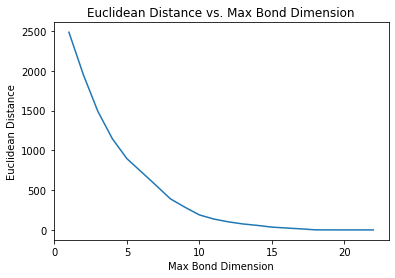

In [13]:
### Compress unneeded dimensions (Normalization removed)
compressions, dist, sim = compress_NN(x[:], threshold=1e-8, compressed_state=MPS[:], plot=1)

In [18]:
### Initialize MPO of right shape (Weights)
M_1 = np.random.rand(1, 1, 4)
M_2 = np.random.rand(1, 1, 10, 7)
M_3 = np.random.rand(1, 1, 1, 7)
M_4 = np.random.rand(1, 1, 4)

W = [M_1] + [M_2] + [M_3] + [M_4]

In [19]:
### Create xW
xW = []
for i in range(len(W)):
    if i == 0 or i == len(W)-1:
        # Contract from top
        site = np.einsum('ij, abi->ajb', x[i], W[i])
        # Transpose since we move from MPO to MPS index notation
        site = np.reshape(site, (W[i].shape[0]*x[i].shape[1], W[i].shape[1]))
        site = site.T
        xW.append(site)
    else:
        # Contract from top
        site = np.einsum('ijk, abck->iajbc', x[i], W[i])
        site = np.reshape(site, (x[i].shape[0]*W[i].shape[0], x[i].shape[1]*W[i].shape[1], W[i].shape[2]))
        xW.append(site)

In [104]:
compressed_xW, best_dist, best_sim = train_NN(y[:], threshold=1e-8, compressed_state=xW[:], plot=0)

Dist: 442.50509666972766
L->R Before (1, 4)
L->R After (1, 4)
L->R Before (4, 28, 10)
L->R After (4, 28, 10)
L->R Before (28, 4, 1)
L->R After (28, 4, 1)
Dist: 1.135682899281653
Dist: 1.0929161509763872
